In [1]:
import os
import cv2
import numpy as np
import torch # 1.9
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.nn import functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A

In [2]:
from dataset import getAllDataPath, CustomImageDataset, show_image
from unet import UNet
from loss import DiceLoss, FocalLoss

In [3]:
BATCH_SIZE = 8
WIDTH = 256
HEIGHT = 256
device = 'cuda:0'

In [4]:
# https://albumentations.ai/docs/getting_started/mask_augmentation/

transform = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
#     A.Rotate((-30, 30), interpolation=0), 
#     A.RandomContrast(limit=0.2, p=1), 

    A.Resize(WIDTH, HEIGHT),
])

target_transform = A.Compose([                       
    A.Resize(WIDTH, HEIGHT),
])

In [5]:
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/CT/'
CT_data = getAllDataPath(root, test_split_size=0.2)
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/MRI/MRI_Label/'
MRI_data = getAllDataPath(root, test_split_size=0.2)
root = './data/CHAOS_AIAdatasets/2_Domain_Adaptation_dataset/MRI/MRI_nonLabel/'
MRI_imgOnly_data = getAllDataPath(root, imgOnly=True)

for data in ['CT_data', 'MRI_data', 'MRI_imgOnly_data']:
    i = eval(data)
    for k in i.keys():
        print(data,k, np.shape(i[k]))


dataset_train = CustomImageDataset(MRI_data['train'], transform=transform, pseudo_label=True)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

dataset_test = CustomImageDataset(MRI_data['test'], transform=target_transform, pseudo_label=False) # **如果要正式使用要記得把這裡換成X_test
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

# CT_dataset_train = CustomImageDataset(CT_data['train'], transform=transform, pseudo_label=True)
# CT_dataloader_train = torch.utils.data.DataLoader(CT_dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# CT_dataset_test = CustomImageDataset(CT_data['test'], transform=target_transform)
# CT_dataloader_test = torch.utils.data.DataLoader(CT_dataset_test, batch_size=BATCH_SIZE, shuffle=False)

CT_data train (2299, 2)
CT_data test (575, 2)
MRI_data train (123, 2)
MRI_data test (31, 2)
MRI_imgOnly_data train (309,)


torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([49403,  4580,  1738,  4243,  2198,  1113,  1313,   890,    33,
          25]), array([0.        , 0.09996842, 0.19993684, 0.29990527, 0.39987367,
       0.4998421 , 0.59981054, 0.699779  , 0.79974735, 0.8997158 ,
       0.9996842 ], dtype=float32)) tensor([0., 1., 2.])


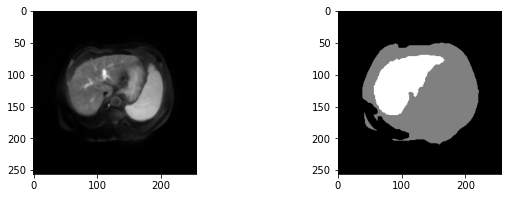

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([42214,  7957,  4301,  5920,   851,   576,  1495,  1383,   611,
         228]), array([0.        , 0.09982009, 0.19964018, 0.2994603 , 0.39928037,
       0.49910048, 0.5989206 , 0.69874066, 0.79856074, 0.8983809 ,
       0.99820095], dtype=float32)) tensor([0., 1., 2.])


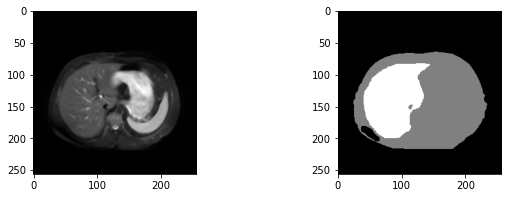

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([48736,  8137,  5366,  1459,   279,   194,   211,   310,   693,
         151]), array([0.        , 0.09991927, 0.19983853, 0.2997578 , 0.39967707,
       0.49959633, 0.5995156 , 0.6994349 , 0.79935414, 0.8992734 ,
       0.99919266], dtype=float32)) tensor([0., 1., 2.])


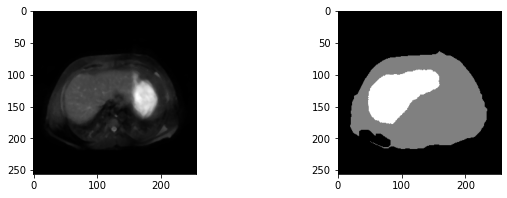

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([47684,  7635,  7009,  1694,   662,   422,   277,    83,    41,
          29]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32)) tensor([0., 1.])


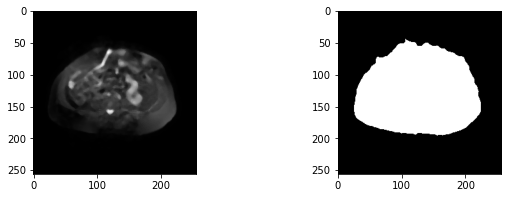

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([46984,  9317,  7055,  1068,   393,   397,   222,    67,     5,
          28]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32)) tensor([0., 1., 2.])


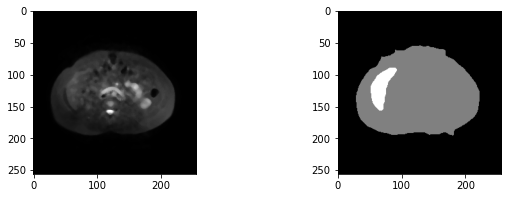

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([43069, 12832,  4563,  1339,   879,  1638,   636,   234,   262,
          84]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32)) tensor([0., 1., 2.])


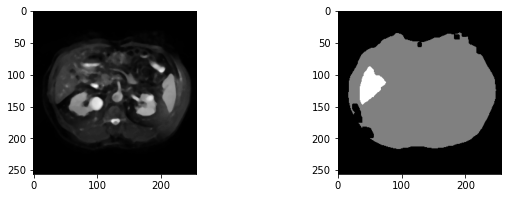

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([52498,  7447,  1975,  1299,   870,   983,   213,    87,   105,
          59]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32)) tensor([0., 1., 2.])


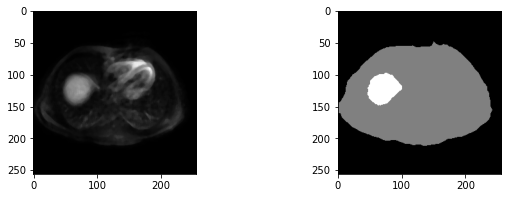

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
(array([51872,  6874,  2254,  2445,  1325,   623,    80,    21,    29,
          13]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32)) tensor([0., 1., 2.])


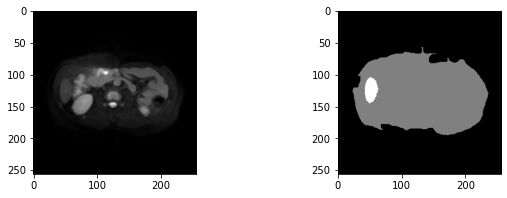

In [6]:
'''
Abs: test transform on dataloader_train.
---
take first image in every batch.
'''
for data in dataloader_train:
    for x, y in zip(*data): 
        print(x.shape, y.shape)
        print(np.histogram(x.numpy()), y.unique())
    
        show_image(x.squeeze(0).numpy(), y.squeeze(0).numpy())

    break

In [7]:
'''
title: create model
---
補充:
- 要在建立optimizer之前就把model的參數移到gpu裡面(也就是在把參數託管給optim以前)
ref: https://pytorch.org/docs/stable/optim.html 
'''

model = UNet
model = model((WIDTH, HEIGHT), in_ch=1, out_ch=3, activation=None).to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-1)

In [8]:
'''
abs: training model
---
- 下面的程序會在3種條件下儲存當前的model(只包含weight)
    - 當前模型的loss是目前以來最低
    - 當前epoch數是20的倍數
    - 完成一個epoch的訓練
'''
from torchvision.ops import sigmoid_focal_loss

EPOCHS = 300
min_target_loss_value = 100
save_root = './data/save_weights/'
os.makedirs(save_root, exist_ok=True)

for epoch in range(EPOCHS):  
    class_loss_value = 0.0
    if epoch < 5:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-5
    elif epoch == 5:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-1
    
            
            
    for i, (source_data, source_label) in enumerate(dataloader_train):
        # zero the parameter gradients
        '''
        abs: zero the parameter gradients
        ---
        這兩種方法都能夠清除variable內的gradient:
        方法1
        param in model.parameters():
        param.grad = None
        方法2 借助optimizer尋找關聯的variable並清除gradient
        optimizer.zero_grad()
        '''
        optimizer.zero_grad()
    
        source_data = source_data.to(device)
        source_label = source_label.to(device)
        
        outputs = model(source_data)
        '''
        abs: single channel'
        ---
        Note:
        - If DiceLloss, outputs = F.sigmoid(outputs)
        - If BCEWithLogitsLoss, outputs不須activation
        '''
#         
#         loss = DiceLoss()(outputs, source_label)
#         loss = torch.nn.MSELoss()(outputs, source_label)
#         loss = torch.nn.BCEWithLogitsLoss(pos_weight = torch.Tensor([100]).to(device))(outputs, source_label)
#         loss = sigmoid_focal_loss(outputs, source_label, reduction='sum')
        
        '''
        title: multi channel
        ---
        Note:
        - If CrossEntropyLoss, source_label should be as channel as outputs. ex: (B, C, W, H)
        - if FocalLoss, source_label should be 1 channel, ex: (B, 1, W, H)
        '''
#         loss = nn.CrossEntropyLoss()(outputs, source_label.long())
        loss = FocalLoss(alpha=[0.05,0.1,1], gamma=1, size_average=False)(outputs, source_label.long())
        class_loss_value += loss.item()

        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(i, end='\r')
        del source_data, source_label, outputs
        torch.cuda.empty_cache()

    class_loss_value /= (i+1)   
    testing_loss_value = class_loss_value

    print(f'epoch: {epoch}, class_loss_value:{class_loss_value}')
    if testing_loss_value < min_target_loss_value:
        min_target_loss_value = testing_loss_value
        print('save best model')
        torch.save(model.state_dict(), f'{save_root}best_model.bin')
    else:
        if epoch%50==49:
            
            torch.save(model.state_dict(), f'{save_root}E{epoch}_model.bin')
        torch.save(model.state_dict(), f'{save_root}model.bin')
    

epoch: 0, class_loss_value:29111.289322916666
epoch: 1, class_loss_value:21271.900651041666
epoch: 2, class_loss_value:17417.492513020832
epoch: 3, class_loss_value:14761.081119791666
epoch: 4, class_loss_value:12820.561458333334
epoch: 5, class_loss_value:57768.03313802083
epoch: 6, class_loss_value:25921.04296875
epoch: 7, class_loss_value:21733.661197916666
epoch: 8, class_loss_value:17597.861002604168
epoch: 9, class_loss_value:14554.500846354167
epoch: 10, class_loss_value:12946.959049479166
epoch: 11, class_loss_value:15400.094075520834
epoch: 12, class_loss_value:14159.544921875
epoch: 13, class_loss_value:14986.8708984375
epoch: 14, class_loss_value:12516.724739583333
epoch: 15, class_loss_value:10958.326822916666
epoch: 16, class_loss_value:10672.066276041667
epoch: 17, class_loss_value:10534.217643229167
epoch: 18, class_loss_value:10076.086263020834
epoch: 19, class_loss_value:9843.049576822918
epoch: 20, class_loss_value:9126.260416666666
epoch: 21, class_loss_value:9101.35

In [8]:
model = UNet
model = model(HEIGHT, in_ch=1, out_ch=3, activation=None).to(device)
save_root = './data/save_weights/'
filepath = f'{save_root}E299_model.bin'
model.load_state_dict(torch.load(filepath)) 

<All keys matched successfully>

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


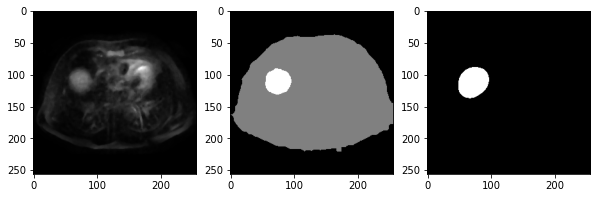

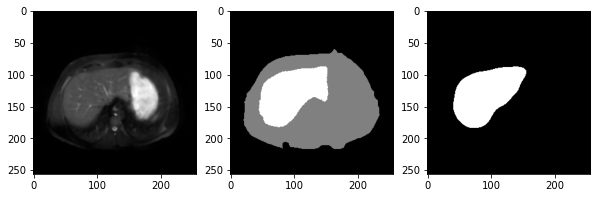

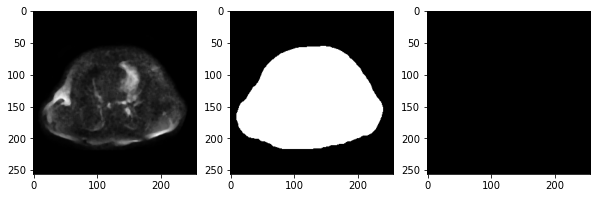

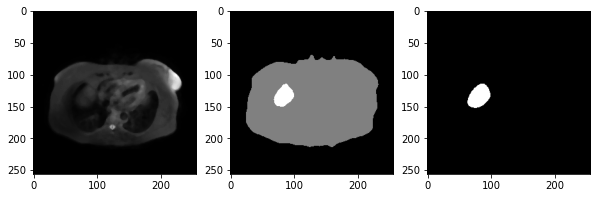

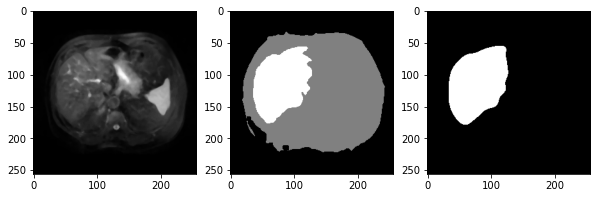

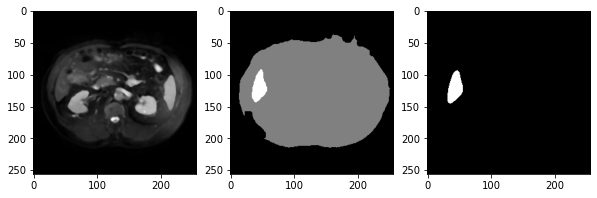

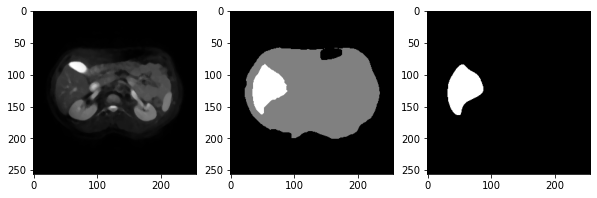

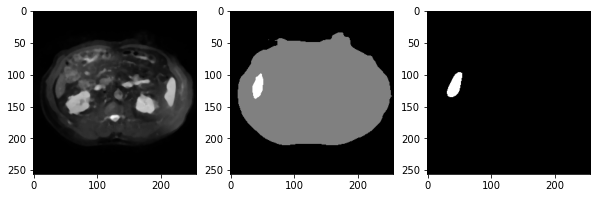

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


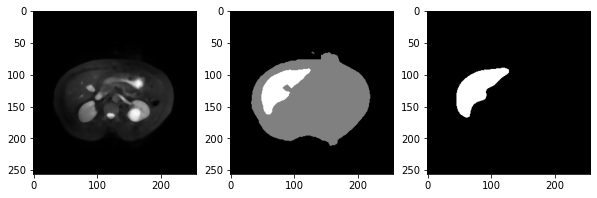

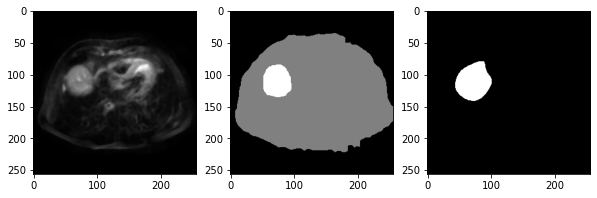

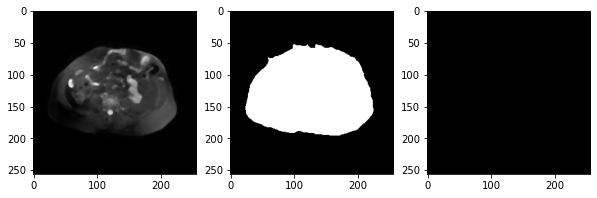

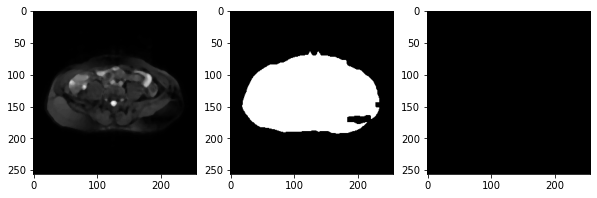

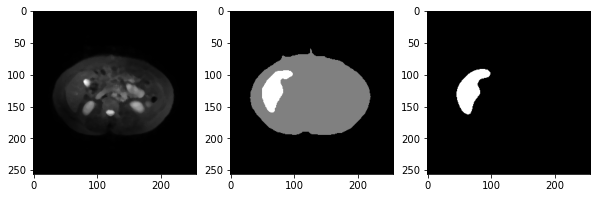

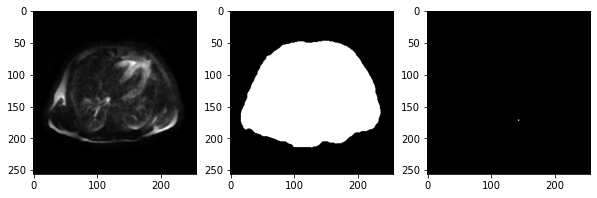

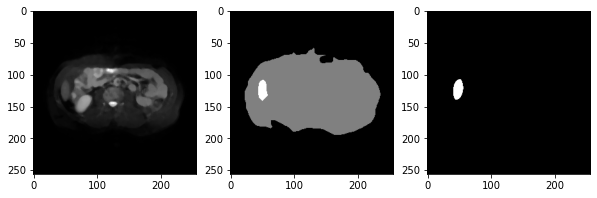

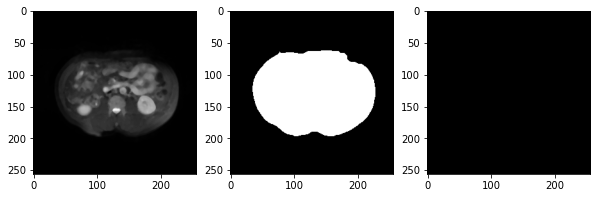

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


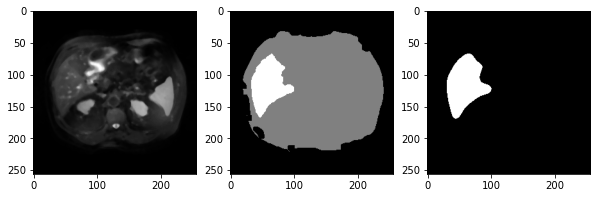

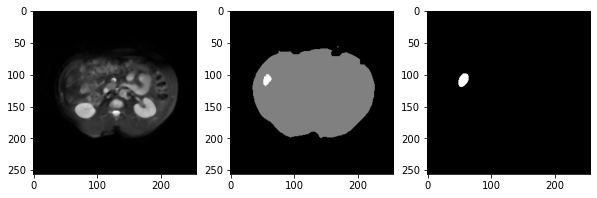

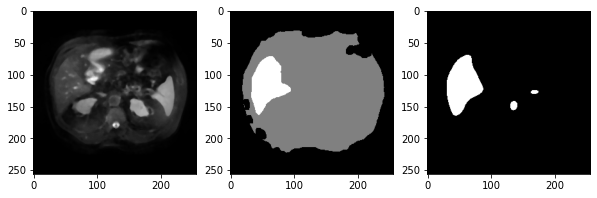

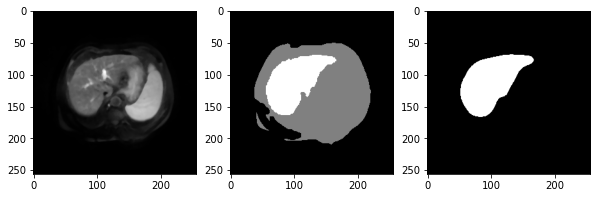

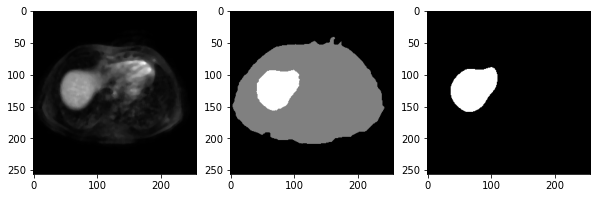

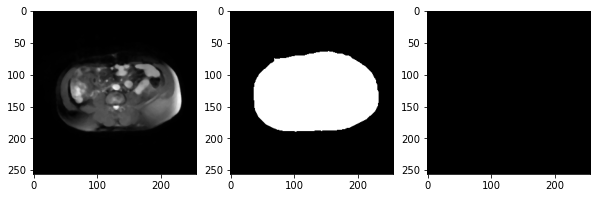

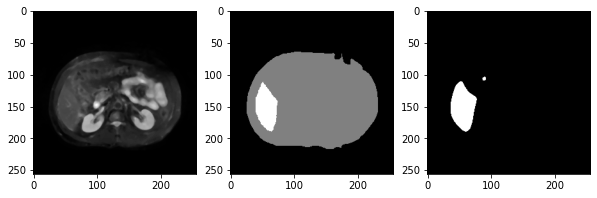

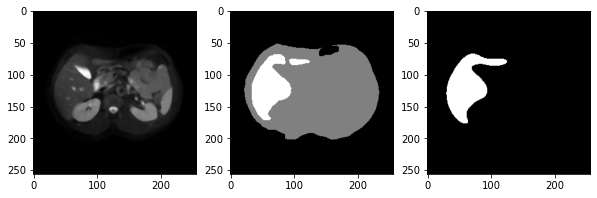

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


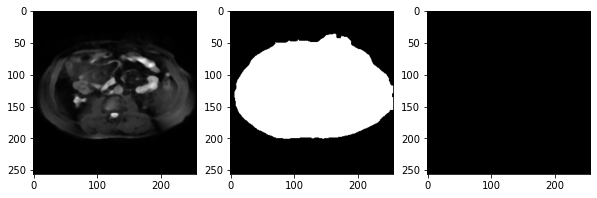

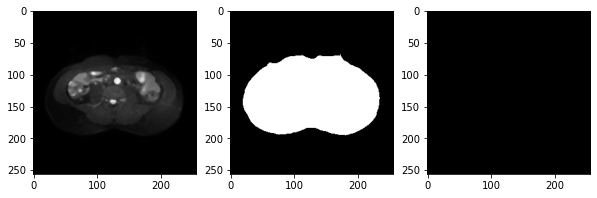

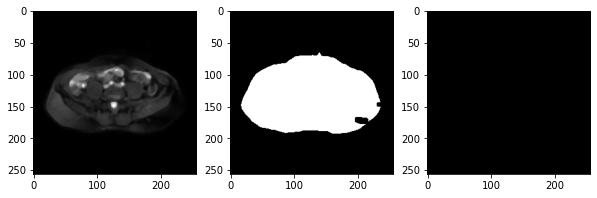

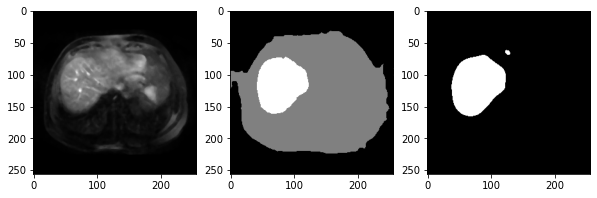

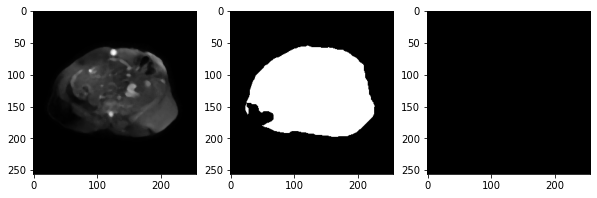

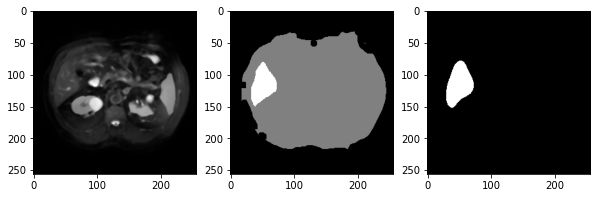

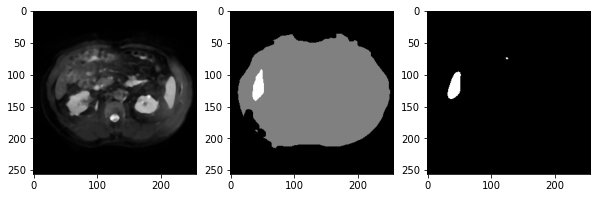

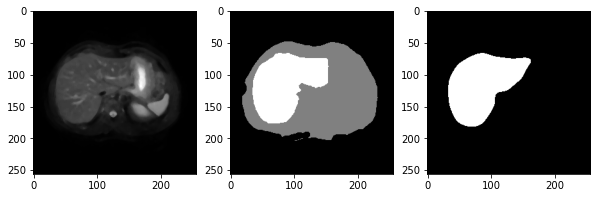

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


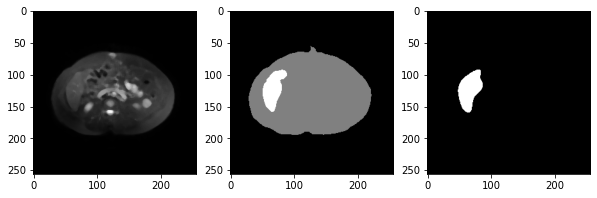

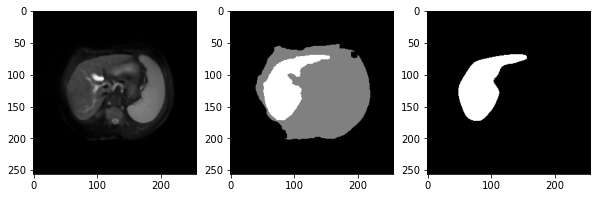

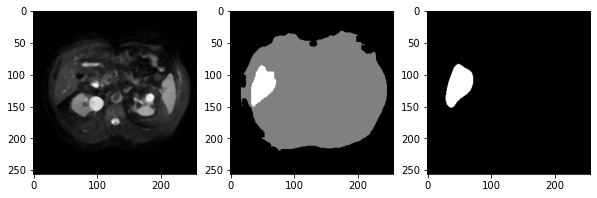

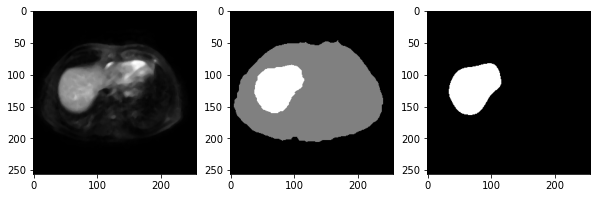

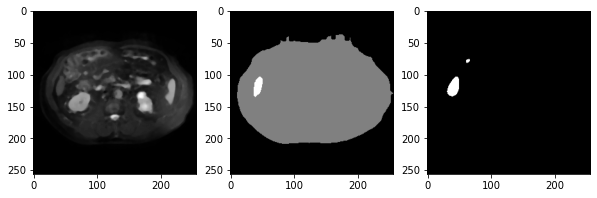

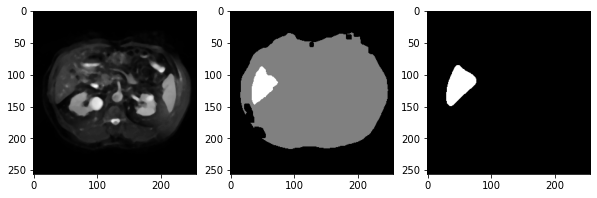

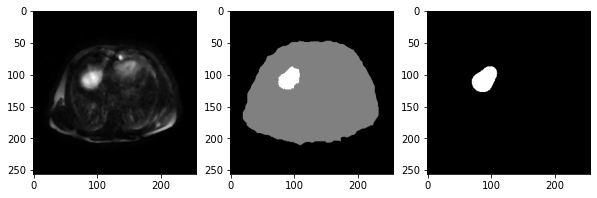

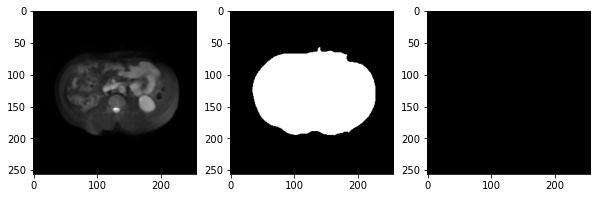

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


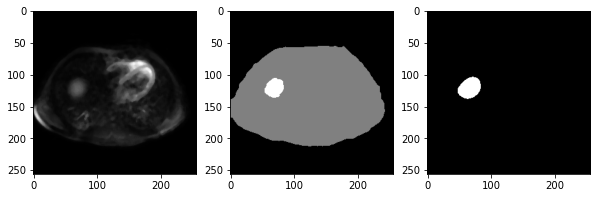

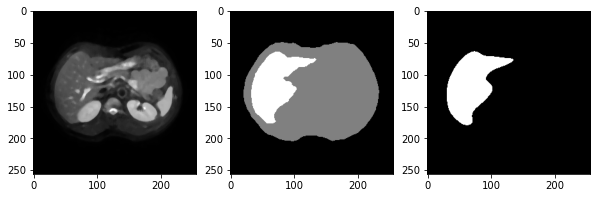

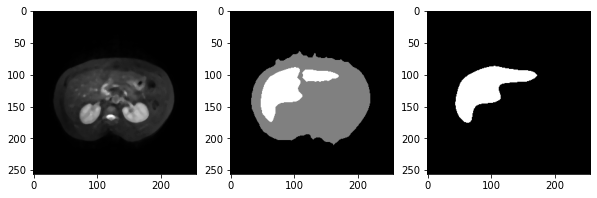

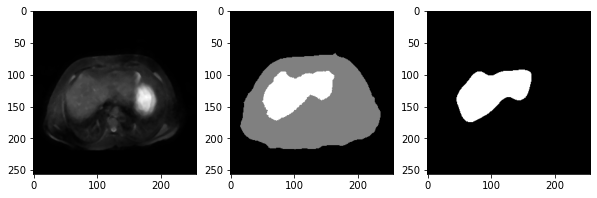

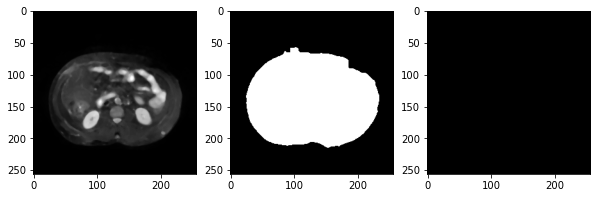

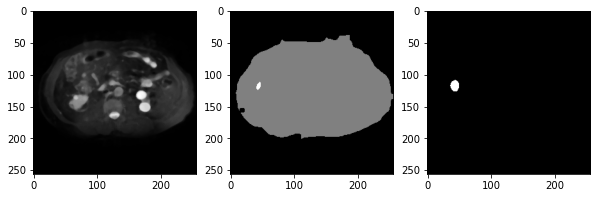

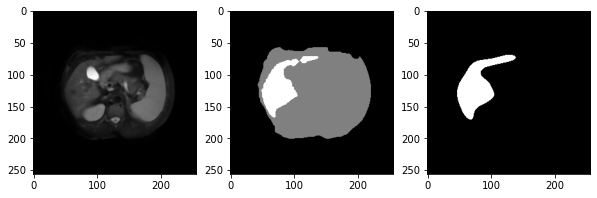

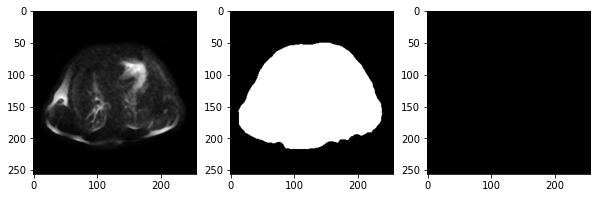

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


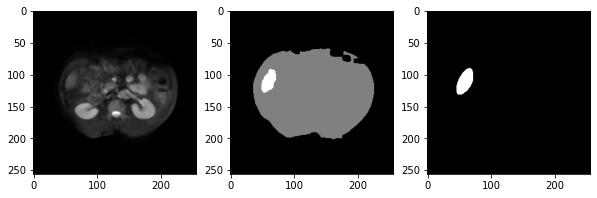

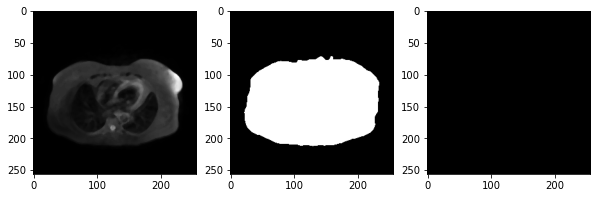

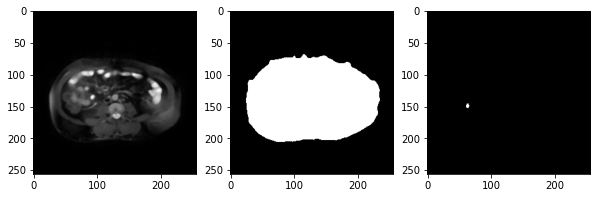

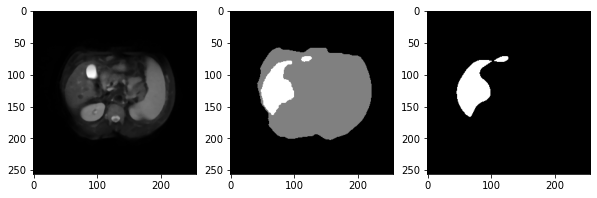

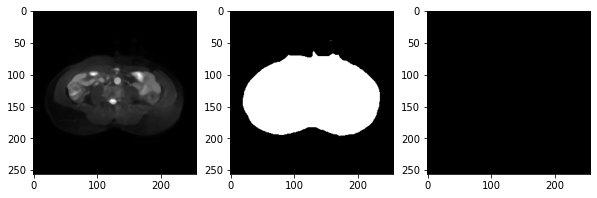

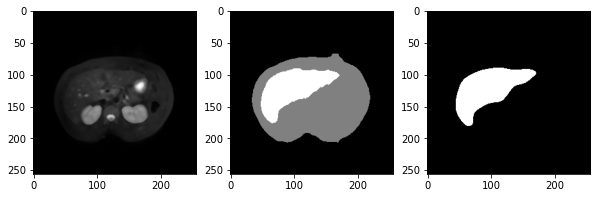

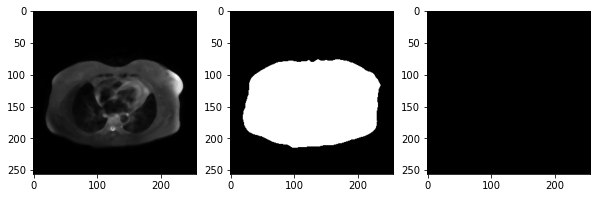

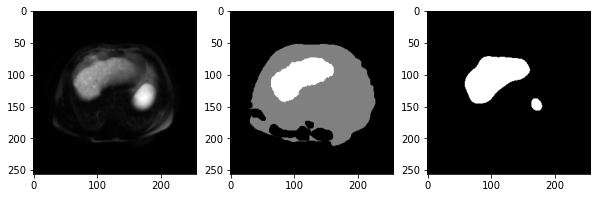

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


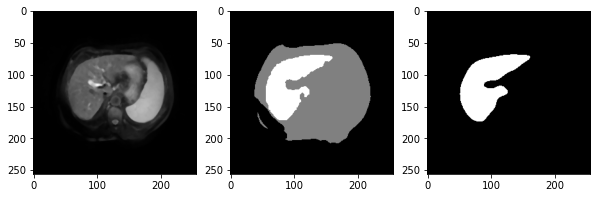

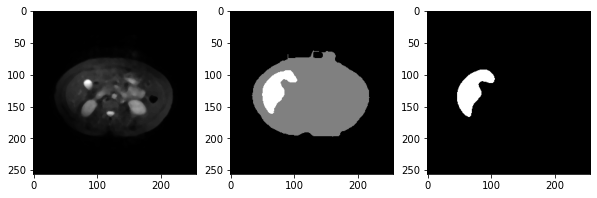

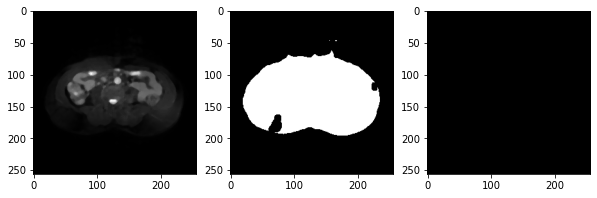

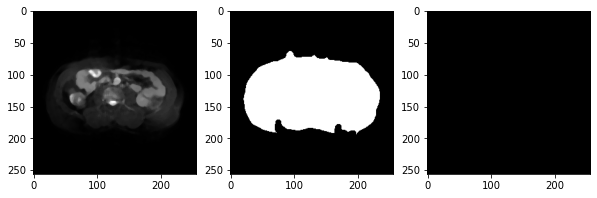

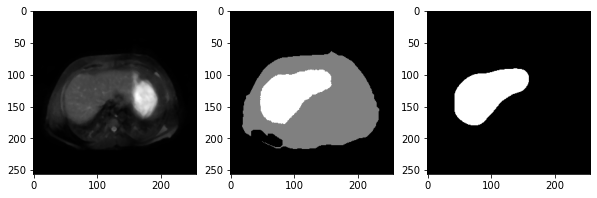

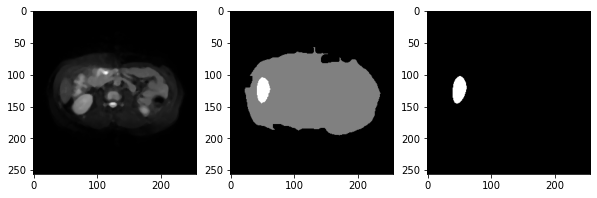

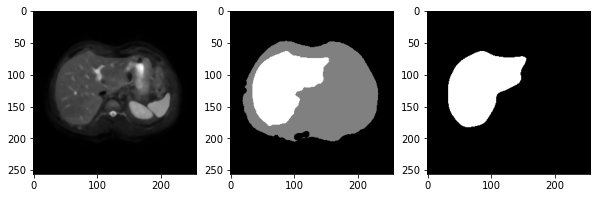

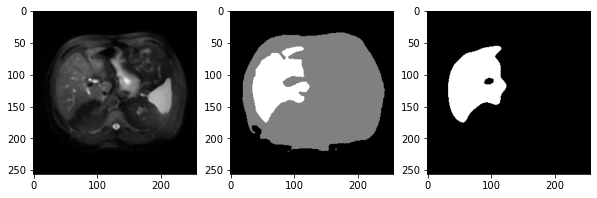

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


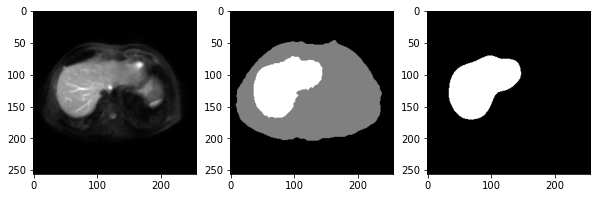

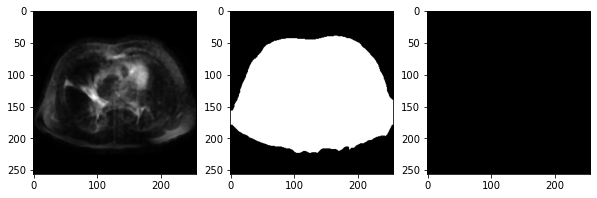

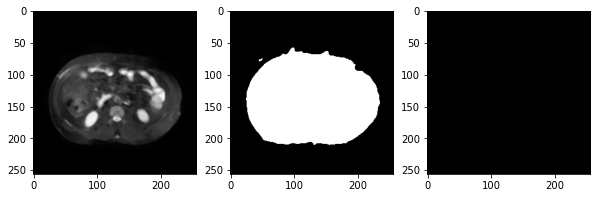

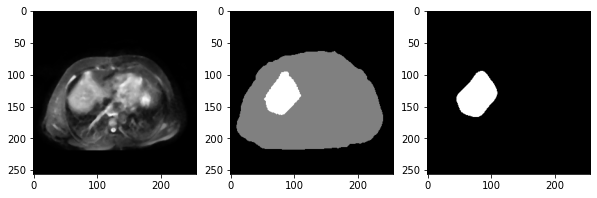

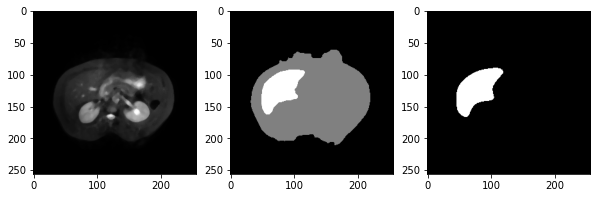

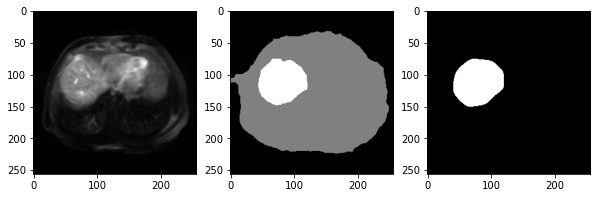

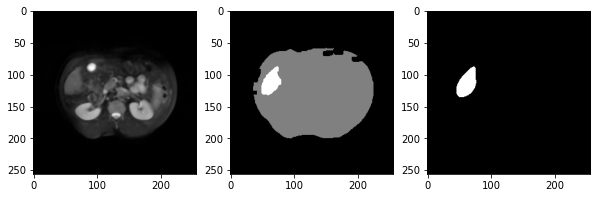

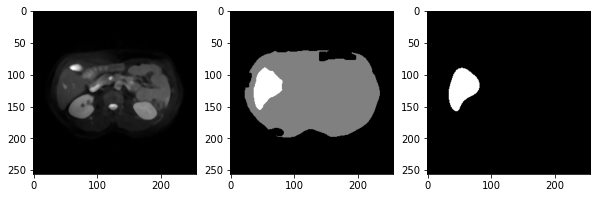

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


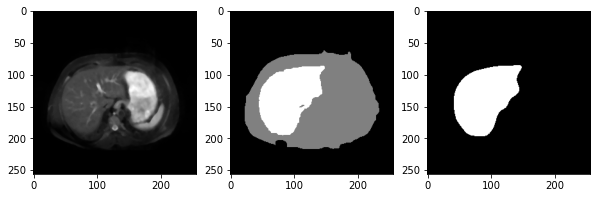

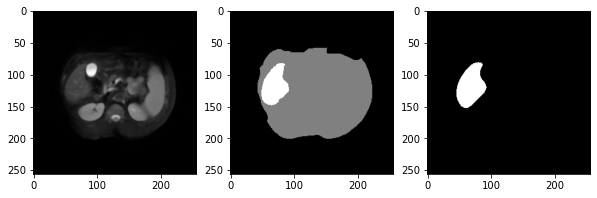

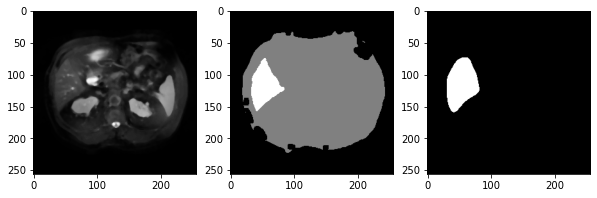

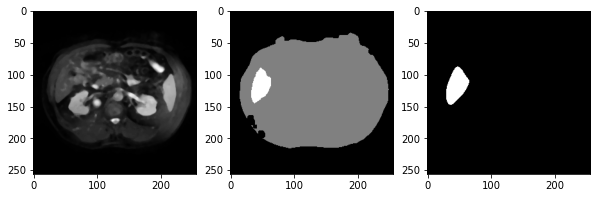

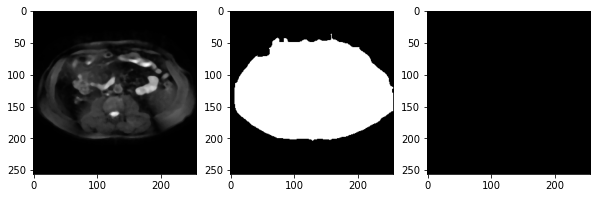

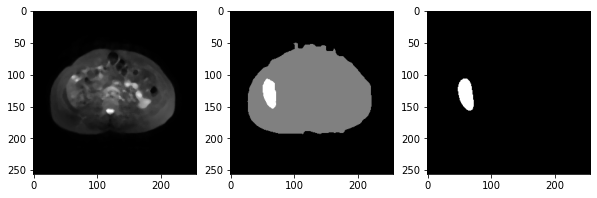

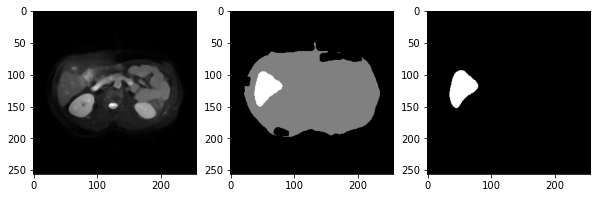

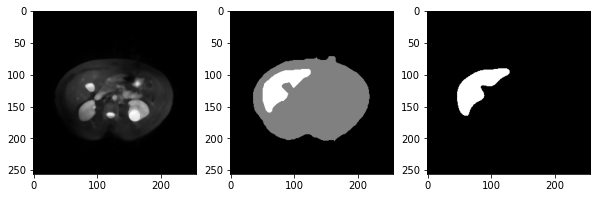

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


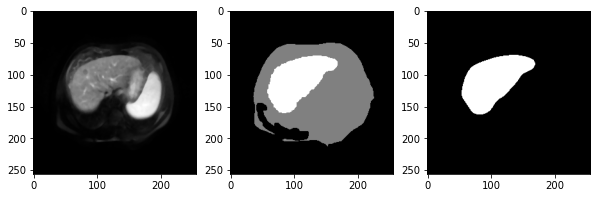

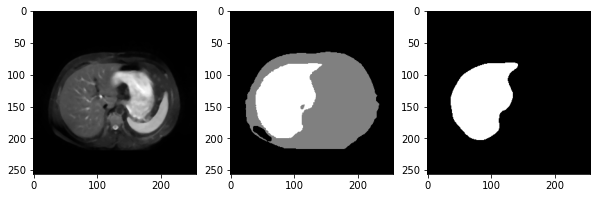

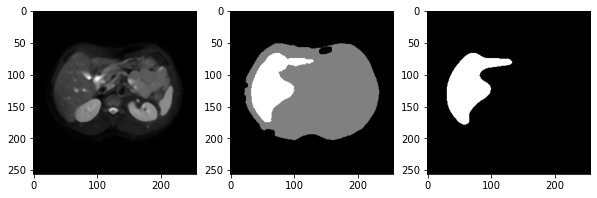

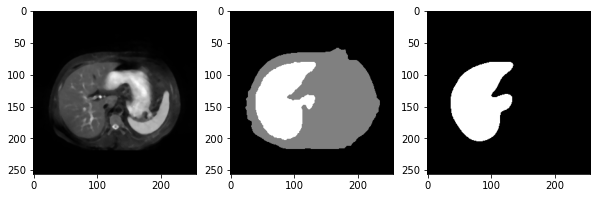

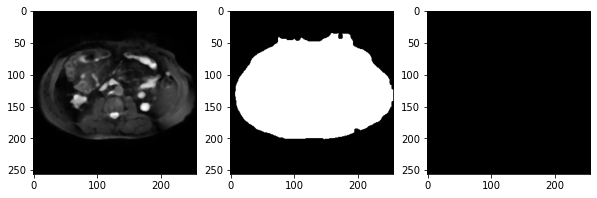

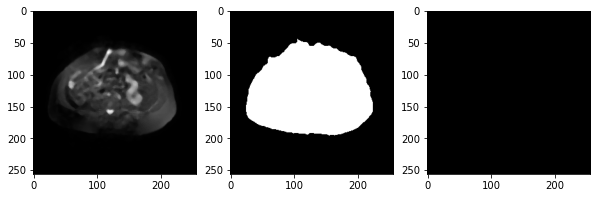

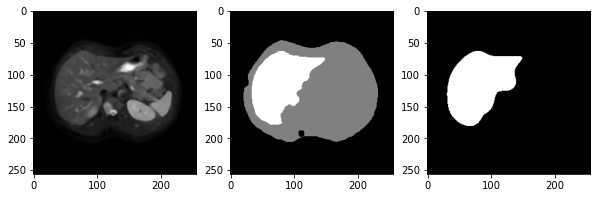

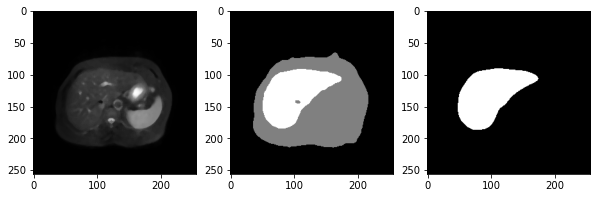

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


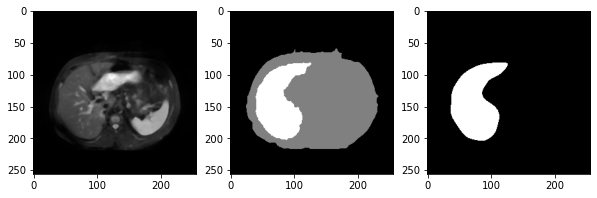

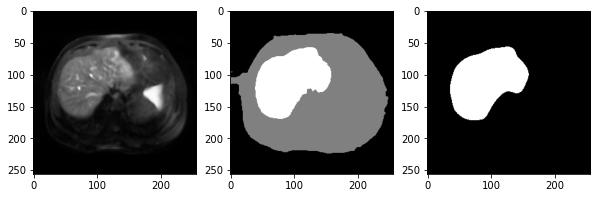

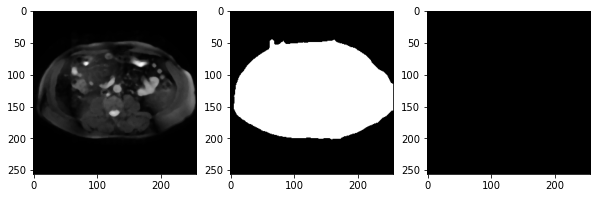

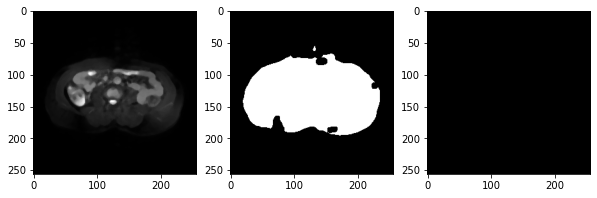

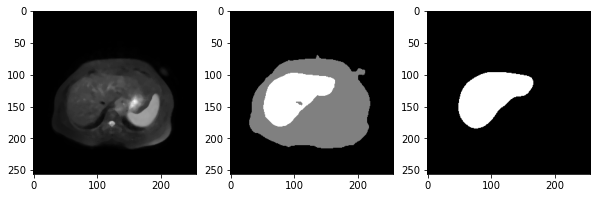

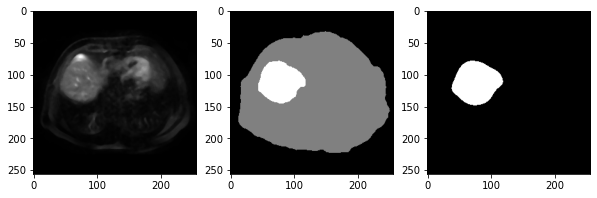

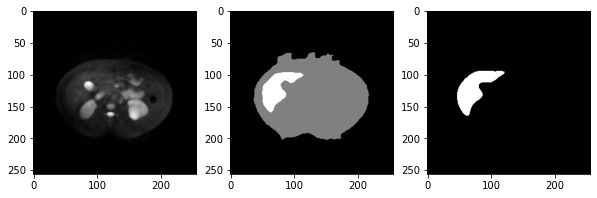

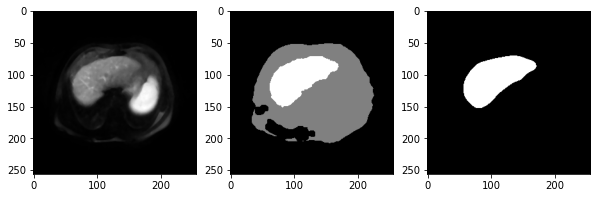

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


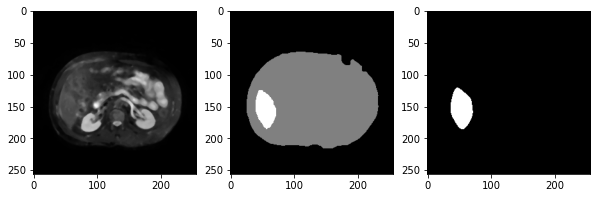

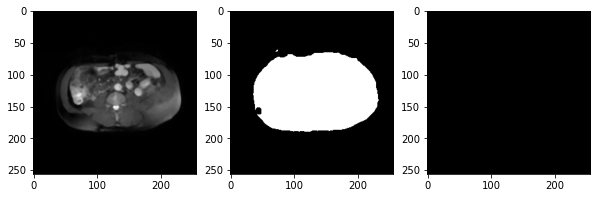

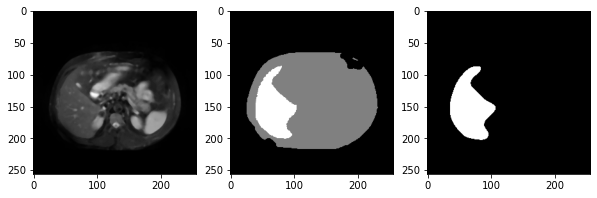

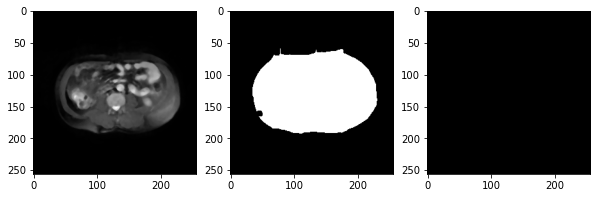

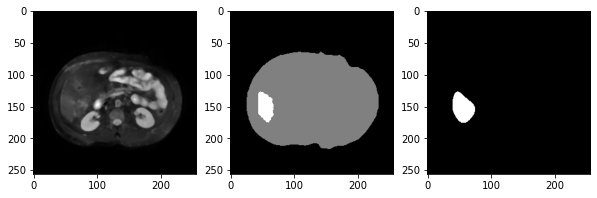

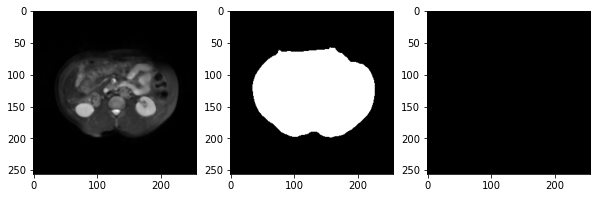

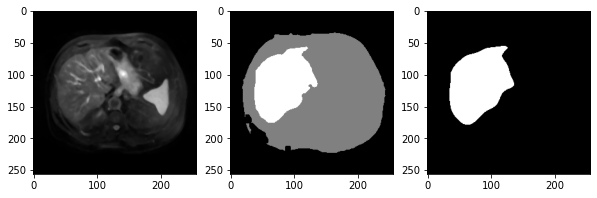

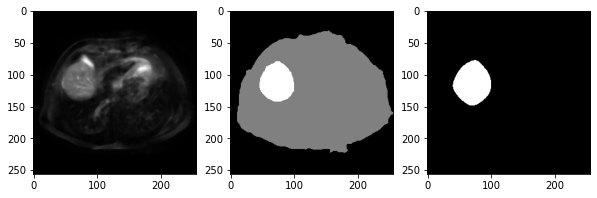

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


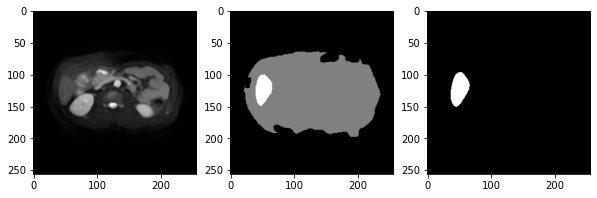

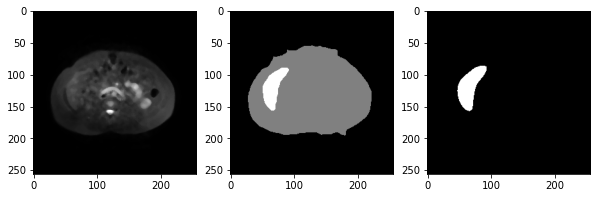

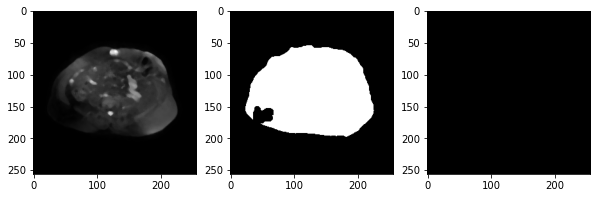

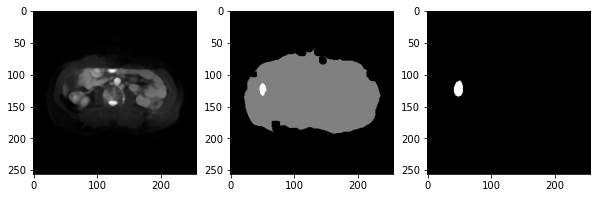

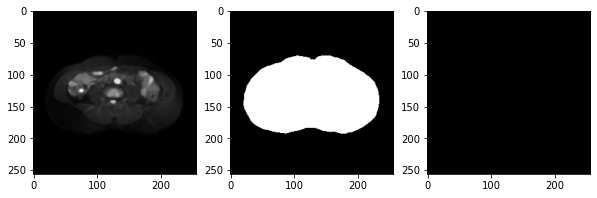

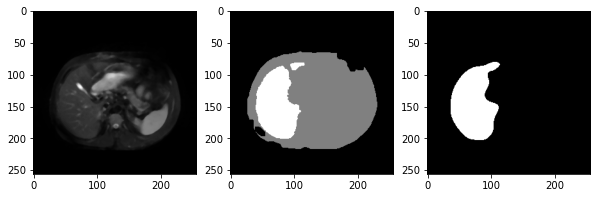

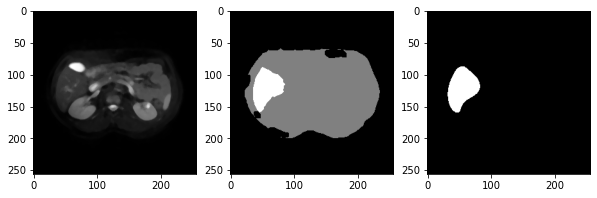

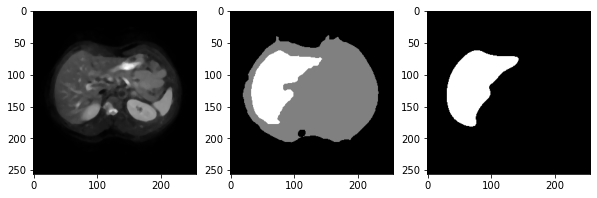

8 torch.Size([8, 1, 256, 256]) torch.Size([8, 1, 256, 256])


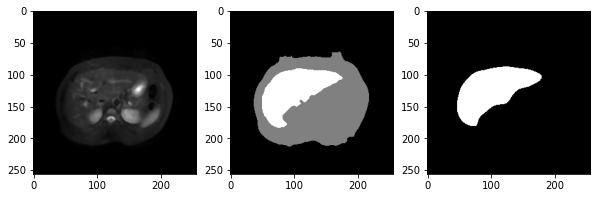

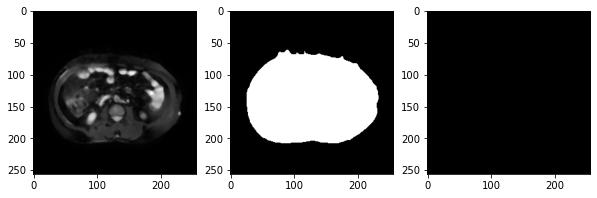

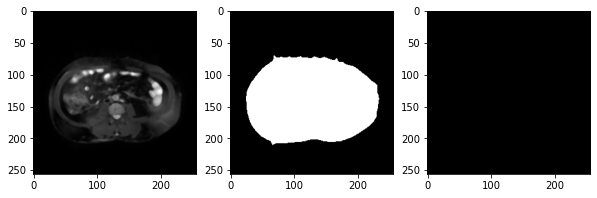

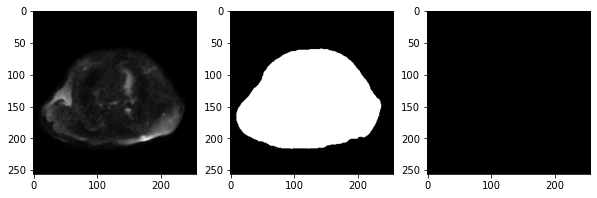

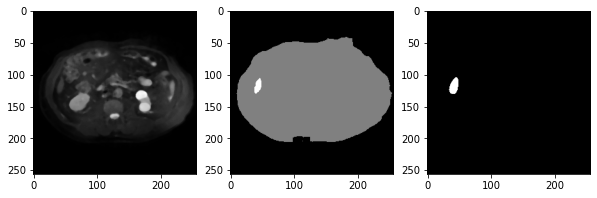

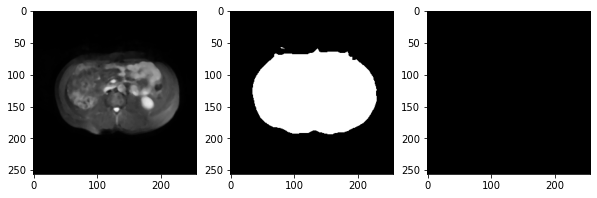

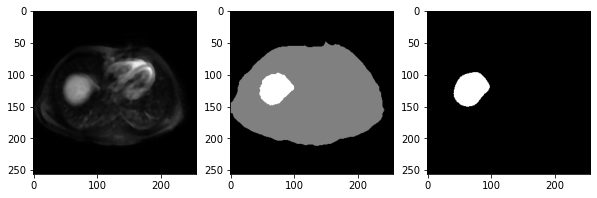

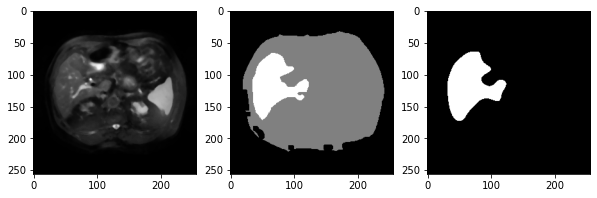

In [15]:
'''
abs: testing model
---
'''

for i, data in enumerate(dataloader_train, 1):
    image, mask = data
    print(len(image), image.shape, mask.shape)
    with torch.no_grad():
        image = image.to(device)
        mask = mask.to(device)
        outputs = model(image)

    'single channel outputs'
#     threshold = 0
#     outputs[outputs>=threshold] = 1.
#     outputs[outputs!=1] = 0.

    'multi channel outputs'
    outputs = F.softmax(outputs)
#     outputs = torch.argmax(outputs, dim=1) # with pseudo label
    outputs = (torch.argmax(outputs, dim=1)==2).int() # only liver segmentation

    img_process = lambda image:image.squeeze(1).cpu().numpy()
    mask_process = lambda mask:mask.squeeze(1).cpu().numpy()

    for x, m, outputs in zip(img_process(image), mask_process(mask), mask_process(outputs)):
        show_image(x, m, outputs)
#         break
            
    del outputs, image, mask

In [ ]:
import os
from IPython import get_ipython
if __name__ == '__main__':
    if get_ipython().__class__.__name__ =='ZMQInteractiveShell':
        os.system('jupyter nbconvert train_unet.ipynb --to python')